In [1]:
import tensorflow as tf
import segmentation_models as sm
import h5py
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from glob import glob

from skimage.filters import median
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

/global/homes/m/mgcho/.local/perlmutter/tensorflow2.9.0/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Segmentation Models: using `keras` framework.


In [ ]:
data_dir  = '/your_training_data_directory/'
model_dir = '/your_model_directory/'

In [4]:
images = h5py.File(data_dir + f'training_images.h5','r')['images']
labels = h5py.File(data_dir + f'training_labels.h5','r')['labels']

In [5]:
print(images.shape)
print(labels.shape)

(256, 512, 512)
(256, 512, 512, 2)


In [6]:
# image stadardization
image_stnd = np.empty([images.shape[0],512,512])

for i in range(0,images.shape[0]):
    img_mean = np.mean(images[i])
    img_std = np.std(images[i])
    image_stnd[i] = (images[i] - img_mean)/img_std

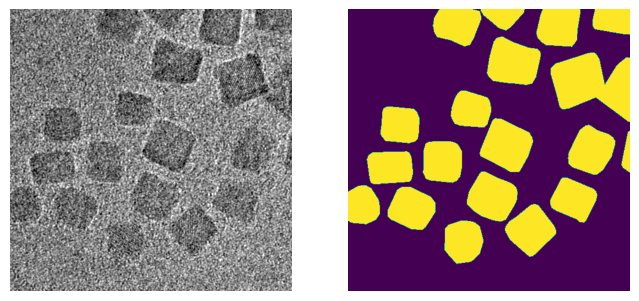

In [32]:
i = 3

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(image_stnd[i], cmap='gray', vmin=-3, vmax=3)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(labels[i,:,:,1])
plt.axis('off')
plt.show()

In [7]:
# setup trainX and trainY
trainX = np.empty([image_stnd.shape[0],512,512,3])
trainX[:,:,:,0] = image_stnd
trainX[:,:,:,1] = image_stnd
trainX[:,:,:,2] = image_stnd

trainY = labels

print(trainX.shape)
print(trainY.shape)

(256, 512, 512, 3)
(256, 512, 512, 2)


In [9]:
fold = 0
k_folds = 8
batch_size = 8
epochs = 100

seed = 42

# Set the learning rate decay parameters
initial_learning_rate = 0.04
decay_rate = 0.5
decay_steps = 20

# Create learning rate scheduler
def lr_scheduler(epoch):
    """Exponential decay learning rate scheduler."""
    lr = initial_learning_rate * (decay_rate ** (epoch / decay_steps))
    return lr

# Create callback for learning rate scheduler
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Split the data into K folds
kf = KFold(n_splits=k_folds, shuffle=True, random_state=seed)
folds = list(kf.split(trainX))

# Create data generator to augment your data
data_gen_args = dict(rotation_range=0, fill_mode='constant', horizontal_flip=True, vertical_flip=True)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

for fold, (train_index, val_index) in enumerate(kf.split(trainX)):
    print(f'Fold {fold+1}/{k_folds}')

    # Get the training and validation data for this fold
    x_train_fold, y_train_fold = trainX[train_index], trainY[train_index]
    x_val_fold, y_val_fold = trainX[val_index], trainY[val_index]

    # Fit the data generators to the training data for this fold
    image_datagen.fit(x_train_fold, augment=True)
    mask_datagen.fit(y_train_fold, augment=True)

    # Create generators for the training and validation data for this fold
    image_generator_train = image_datagen.flow(x_train_fold, batch_size=batch_size, seed=seed)
    mask_generator_train = mask_datagen.flow(y_train_fold, batch_size=batch_size, seed=seed)
    image_generator_val = image_datagen.flow(x_val_fold, batch_size=batch_size, seed=seed)
    mask_generator_val = mask_datagen.flow(y_val_fold, batch_size=batch_size, seed=seed)

    # Combine the generators for the training and validation data for this fold
    train_generator = zip(image_generator_train, mask_generator_train)
    val_generator = zip(image_generator_val, mask_generator_val)

    # Setup model
    model = sm.Unet('resnet18', encoder_weights=None, classes=2, activation='softmax')
    model.compile(
        optimizer=Adam(learning_rate=initial_learning_rate),
        loss=sm.losses.cce_dice_loss,
        metrics=[sm.metrics.iou_score, sm.metrics.f1_score],
    )

    # Set the filenames for the saved model weights and history for this fold
    save_weights = model_dir + f'unet_noPretrain_fold{fold+1}_weights.h5'
    save_history = model_dir + f'unet_noPretrain_fold{fold+1}_history.h5'

    # Setup checkpoints so that you can save during training
    model_checkpoint = ModelCheckpoint(save_weights,
                                        monitor = 'val_loss',
                                        save_best_only = True,
                                        mode = 'min',
                                        verbose = 0,
                                        save_weights_only = True)
    callbacks_list = [model_checkpoint, lr_callback]

    history = model.fit(
        train_generator, epochs=epochs, steps_per_epoch=len(x_train_fold) // batch_size,
        validation_data=val_generator, validation_steps=len(x_val_fold) // batch_size,
        callbacks=callbacks_list,
        verbose=0,
        )

    h = h5py.File(save_history,'w')
    h_keys = history.history.keys()
    
    for k in h_keys:
        h.create_dataset(k,data=history.history[k])
    h.close()    

Fold 1/8
Fold 2/8
Fold 3/8
Fold 4/8
Fold 5/8
Fold 6/8
Fold 7/8
Fold 8/8


In [10]:
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_144 (ZeroPaddin  (None, None, None,   0          ['bn_data[0][0]']                
 g2D)                           3)                                                         